In [111]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

In [152]:
#choose filepath to desired data
path = 'C:\\Users\\khart\Documents\\IRCSP2_data\\NUC\\mar02\\'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  'C:\\Users\\khart\Documents\\IRCSP2_data\\calibration_files\\cam1pixel.h5'
cal_file1 =  'C:\\Users\\khart\Documents\\IRCSP2_data\\calibration_files\\cam2pixel.h5'

In [162]:
waves= np.linspace(7,12,61)
temps = [56,57,58,59,61,62]
angles = np.round(np.linspace(-5,5,25),1)

In [163]:
#import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC
cal_path = 'C:\\Users\\khart\Documents\\IRCSP2_data\\calibration_files\\NUC030221.h5'

m1,b1,T_ref1,m2,b2,T_ref2 = import_NUC(cal_path)

In [164]:
#apply pixel registration and NUC to full dataset

#select ROI
ymin2 = 105; ymax2 = 130;
ymin1 = 130; ymax1 = 155;

mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]

mean_ims1n =[]
mean_ims2n =[]
std_ims1n  =[]
std_ims2n  =[]

for i in temps:
    #will create a df and print the names of the keys in the original hdf5 file
    df = create_LUT_df(path,str(i)+'C.h5')
    
    corrected_images1= [] ; corrected_images1n= [];
    corrected_images2= [] ; corrected_images2n= []

    for i in range(len(df)):
        #first without NUC correction
        r = df['imgs1'][i];
        c = pixel_registration(r,cal_file1,waves,ymin1,ymax1)
        
        #now with NUC correction
        T = df['temps1'][i];
        rn = apply_NUC(r,T,m1,b1,T_ref1)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        
        corrected_images1.append(c)
        corrected_images1n.append(cn)

    for i in range(len(df)):
        #first without NUC correction
        r = df['imgs2'][i];
        c = pixel_registration(r,cal_file2,waves,ymin2,ymax2)
        
        #now with NUC correction
        T = df['temps2'][i];
        rn = apply_NUC(r,T,m2,b2,T_ref2)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        
        corrected_images2.append(c)
        corrected_images2n.append(cn)

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims1n.append(np.mean(corrected_images1n,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))
    mean_ims2n.append(np.mean(corrected_images2n,axis = 0))


    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))
    std_ims1n.append(np.std(corrected_images1n,axis = 0))
    std_ims2n.append(np.std(corrected_images2n,axis = 0))

In [165]:
d = {'BB_temps': temps, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}
dn = {'BB_temps': temps, 'ims1': list(mean_ims1n),'s1': list(std_ims1n), 'ims2':list(mean_ims2n),'s2': list(std_ims2n)}


In [166]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

dfn = pd.DataFrame.from_dict(dn, orient='index')
dfn = dfn.transpose()

df

,BB_temps,ims1,s1,ims2,s2
0,56,"[[22128.92, 22132.12, 22137.34, 22137.22, 2212...","[[10.752376481503982, 9.609661804663057, 8.583...","[[22751.08, 22751.78, 22759.04, 22767.38, 2277...","[[8.555325826641552, 8.355932024615807, 6.9482..."
1,57,"[[22121.34, 22125.46, 22132.88, 22133.12, 2212...","[[5.890195242943989, 5.5388085361384345, 6.340...","[[22744.86, 22746.74, 22755.88, 22762.64, 2277...","[[4.486691431333339, 4.233485561567442, 4.9097..."
2,58,"[[22133.08, 22134.48, 22140.42, 22143.78, 2213...","[[8.840452477107718, 7.778791679946185, 8.0506...","[[22752.1, 22753.18, 22763.16, 22774.0, 22781....","[[8.896066546513692, 8.435496428782361, 7.4722..."
3,59,"[[22124.15, 22128.55, 22130.85, 22132.55, 2212...","[[6.2251506005879085, 6.69496079152074, 5.6349...","[[22747.85, 22749.75, 22759.05, 22769.35, 2277...","[[4.7908767464838835, 3.887479903485033, 2.936..."
4,61,"[[22130.35, 22134.95, 22144.2, 22145.9, 22139....","[[4.588300338905464, 3.8564880396547325, 5.395...","[[22755.15, 22758.9, 22768.55, 22777.3, 22785....","[[6.02930344235551, 5.739337940912697, 4.88594..."
5,62,"[[22132.55, 22135.6, 22145.15, 22147.5, 22138....","[[4.058632774716136, 5.919459434779497, 6.2571...","[[22757.45, 22758.9, 22767.45, 22777.4, 22786....","[[5.917981074657134, 5.80430874437258, 6.59336..."


In [9]:

#df.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_no_NUC.h5', key='s')
#dfn.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_NUC.h5', key='s')


In [10]:
def finv(y,A,B):
    return ((y-B)/A)**0.5


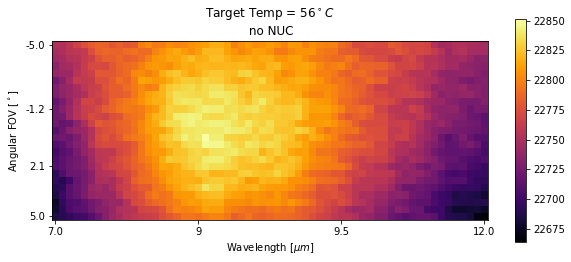

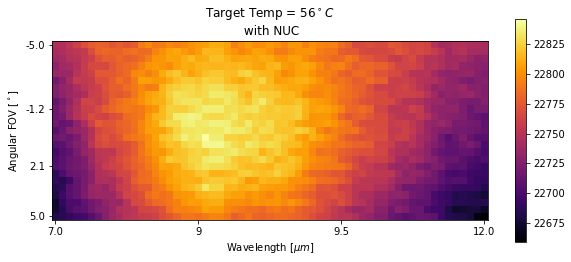

In [167]:
cmin = np.min(list(df['ims1'])); cmax=np.max(list(df['ims2']))

j = 0;
plt.matshow(df['ims2'][j],cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$ \n no NUC')
#plt.clim(cmin,cmax)
plt.show()

cmin = np.min(list(dfn['ims1'])); cmax=np.max(list(df['ims2']))

plt.matshow(dfn['ims2'][j],cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$ \n with NUC')
plt.show()

In [169]:
#create sum column
df["totalrad"] = df['ims2']+df['ims1']
df["totalstd"] = (df['s2']**2+df['s1']**2)**0.5

dfn["totalrad"] = dfn['ims2']+dfn['ims1']
dfn["totalstd"] = (dfn['s2']**2+dfn['s1']**2)**0.5

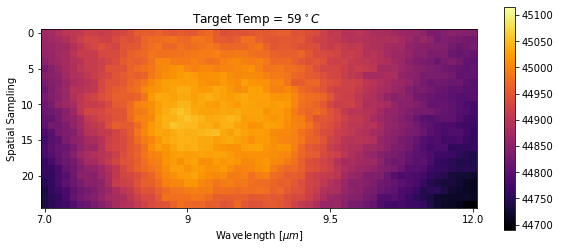

In [170]:
cmin = np.min(list(df['totalrad'])); cmax=np.max(list(df['totalrad']))

j = 3;
plt.matshow(df['totalrad'][j],cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$  ')
plt.clim(cmin,cmax)
plt.show()

In [171]:
# pixel fit 
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x**2 + B

def finv(y,A,B):
    return ((y-B)/A)**0.5


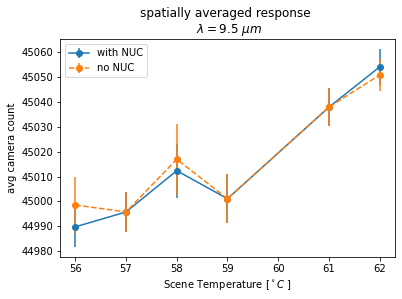

In [172]:
x =30
plt.errorbar(dfn['BB_temps'],get_slice_avg(dfn['totalrad'],x),yerr=get_slice_avg(dfn['totalstd'],x),fmt='o-', label = 'with NUC')
plt.errorbar(df['BB_temps'],get_slice_avg(df['totalrad'],x),yerr=get_slice_avg(df['totalstd'],x),fmt='o--',label = 'no NUC')
plt.title('spatially averaged response \n $\lambda = $' + str(round(waves[x],2)) + ' $  \mu m$')
plt.xlabel('Scene Temperature [$^\circ C$ ] ')
plt.ylabel('avg camera count')
plt.legend()
plt.show()


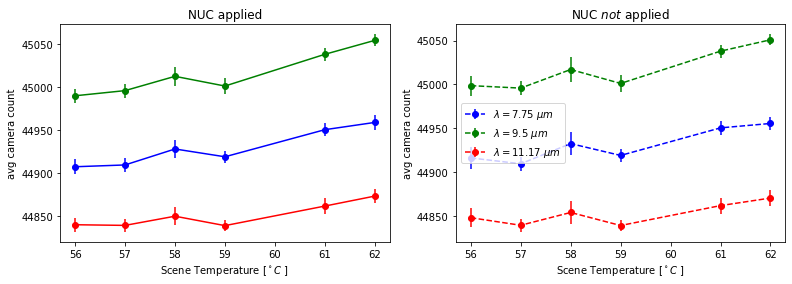

In [173]:
xs =[9,30,50];
colors = ['b','g','r']
fig, axes = plt.subplots(ncols=2, figsize=(13, 4), tight_layout=False)

ax1, ax2 = axes
for i in range(3):
    ax1.errorbar(dfn['BB_temps'],get_slice_avg(dfn['totalrad'],xs[i]),yerr=get_slice_avg(dfn['totalstd'],xs[i]),fmt='o-', c =colors[i],label = '$\lambda = $' + str(round(waves[xs[i]],2)) + ' $  \mu m$')
    ax2.errorbar(df['BB_temps'],get_slice_avg(df['totalrad'],xs[i]),yerr=get_slice_avg(df['totalstd'],xs[i]),fmt='o--', c =colors[i],label = '$\lambda = $' + str(round(waves[xs[i]],2)) + ' $  \mu m$')
ax1.set_title('NUC applied')
ax2.set_title('NUC $not$ applied')
ax1.set_xlabel('Scene Temperature [$^\circ C$ ] ')
ax1.set_ylabel('avg camera count')
ax2.set_xlabel('Scene Temperature [$^\circ C$ ] ')
ax2.set_ylabel('avg camera count')
ax2.legend()
plt.show()

In [179]:
#make a plot of response vs. wavelength for bb temp
response1 = [];
std1 = []
response2 = [];
std2 = []
for i in range(len(waves)):
    sli1= get_slice_avg(dfn['ims1'],i)
    s1= get_slice_avg(dfn['s1'],i)
    response1.append(sli1)
    std1.append(s1)
    
    sli2= get_slice_avg(dfn['ims2'],i)
    s2= get_slice_avg(dfn['s2'],i)
    response2.append(sli2)
    std2.append(s2)

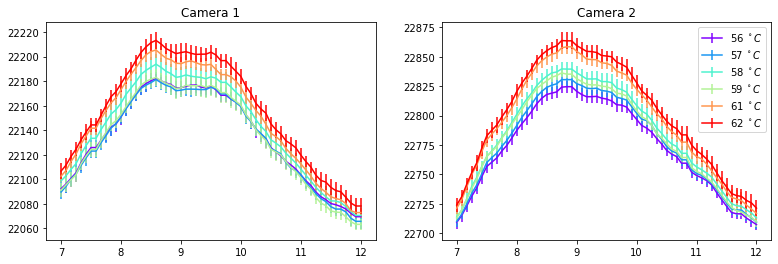

In [185]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(temps)))
fig, axes = plt.subplots(ncols=2, figsize=(13, 4), tight_layout=False)
ax1, ax2 = axes
for i in range(len(temps)):
    ax1.errorbar(waves, np.transpose(response1)[i],yerr=np.transpose(std1)[i],label = str(temps[i])+' $^\circ C$',c=colors[i])
    ax2.errorbar(waves, np.transpose(response2)[i],yerr=np.transpose(std2)[i],label = str(temps[i])+' $^\circ C$',c=colors[i])
plt.legend()
ax1.set_title('Camera 1')
ax2.set_title('Camera 2')
plt.show()

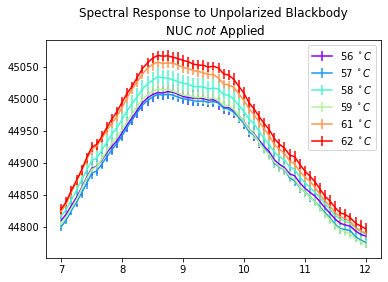

In [127]:
#make a plot of response vs. wavelength for bb temp
response = [];
std = []
for i in range(len(waves)):
    sli= get_slice_avg(df['totalrad'],i)
    s= get_slice_avg(df['totalstd'],i)
    response.append(sli)
    std.append(s)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(temps)))
for i in range(len(temps)):
    plt.errorbar(waves, np.transpose(response)[i],yerr=np.transpose(std)[i],label = str(temps[i])+' $^\circ C$',c=colors[i])
plt.legend()
plt.title('Spectral Response to Unpolarized Blackbody\n NUC $not$ Applied')
plt.show()

In [128]:
def get_slice(df,x,y):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(s[y,x])
    return(sli)

def get_slice_avg(df,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(np.mean(s[:,x]))
    return(sli)

In [129]:

def calc_rad_coef(db):
    '''do pixel by pixel fit and determine A and B coefficients'''
    spec = len(db['ims1'][1][1])
    spat = len(db['ims1'][1])
    Ts = df['BB_temps'];
    
    #preallocate coefficient arrays
    A1 = np.zeros([spat,spec]);B1 = np.zeros([spat,spec]);
    A2 = np.zeros([spat,spec]);B2 = np.zeros([spat,spec]);
    At = np.zeros([spat,spec]);Bt = np.zeros([spat,spec]);
    
    for i in range(spat):
        for j in range(spec):
            rs1 = get_slice(db['ims1'],j,i)
            rs2 = get_slice(db['ims2'],j,i)
            [a1,b1],cov1 = curve_fit(f, Ts, rs1)
            [a2,b2],cov2 = curve_fit(f, Ts, rs2)
            [at,bt],covt = curve_fit(f, Ts, np.add(rs1,rs2))
            A1[i,j] = a1;B1[i,j] =b1
            A2[i,j] = a2;B2[i,j] =b2
            At[i,j] = at;Bt[i,j] =bt
    return([A1,B1],[A2,B2],[At,Bt])        
 

In [130]:
[A1,B1],[A2,B2],[At,Bt] = calc_rad_coef(df)

In [131]:
[A1n,B1n],[A2n,B2n],[Atn,Btn] = calc_rad_coef(dfn)

In [146]:
#writetohdf5

#choose filepath to desired data
save_path =   'C:\\Users\\khart\Documents\\IRCSP2_data\\calibration_files\\'
name =  "LUT030221" 

#create hdf5 file
hf = h5py.File(save_path + name + '.h5', 'w')
hf.create_dataset('/A1',  data= A1)
hf.create_dataset('/B1',  data= B1)
hf.create_dataset('/A2',  data= A2)
hf.create_dataset('/B2',  data= B2)
hf.create_dataset('/At',  data= At)
hf.create_dataset('/Bt',  data= Bt)

hf.create_dataset('/A1n',  data= A1n)
hf.create_dataset('/B1n',  data= B1n)
hf.create_dataset('/A2n',  data= A2n)
hf.create_dataset('/B2n',  data= B2n)
hf.create_dataset('/Atn',  data= Atn)
hf.create_dataset('/Btn',  data= Btn)
hf.close()

In [147]:
def radiometric_retrieval(df,j,At,Bt):
    #attempt retrival
    Ts= np.zeros([25,len(waves)])
    for w in range(len(waves)):
        for s in range(25):
            data= list(df['ims1'][j]+df['ims2'][j])[s][w]
            A = At[s][w]
            B = Bt[s][w]
            t = finv(data,A,B)
            Ts[s][w] = t
    return(Ts)        

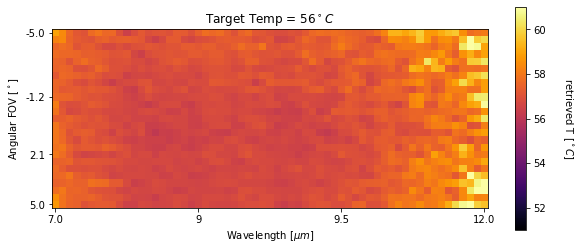

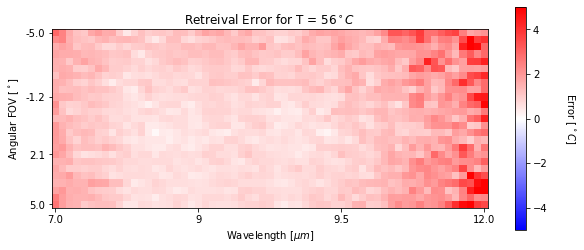

In [148]:
j = 0 ;
Ts = radiometric_retrieval(df,j,At,Bt) 


plt.matshow(Ts,cmap = 'inferno' )
cbar = plt.colorbar()
cbar.set_label('retrieved T [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$')
plt.clim(temps[j]-5,temps[j]+5)
plt.show()

plt.matshow(Ts-temps[j],cmap = 'bwr' )
cbar = plt.colorbar()
cbar.set_label('Error [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Angular FOV [$^\circ$]') 
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Retreival Error for T = ' + str(temps[j])+ '$^\circ C$')
plt.clim(-5,5)
plt.show()

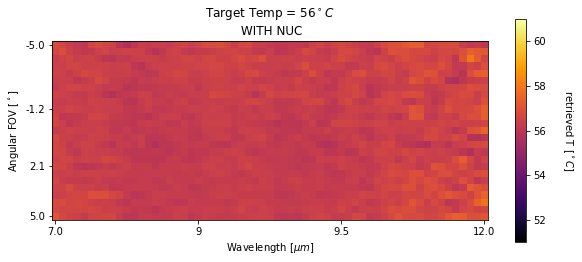

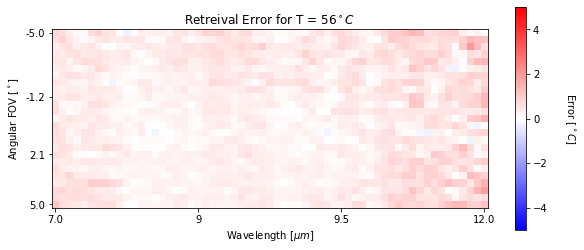

In [145]:
j = 0 ;
Ts = radiometric_retrieval(dfn,j,Atn,Btn) 


plt.matshow(Ts,cmap = 'inferno' )
cbar = plt.colorbar()
cbar.set_label('retrieved T [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$ \n WITH NUC')
plt.clim(temps[j]-5,temps[j]+5)
plt.show()

plt.matshow(Ts-temps[j],cmap = 'bwr' )
cbar = plt.colorbar()
cbar.set_label('Error [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Angular FOV [$^\circ$]') 
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Retreival Error for T = ' + str(temps[j])+ '$^\circ C$')
plt.clim(-5,5)
plt.show()

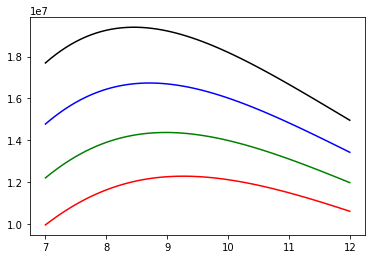

In [190]:
'''compare to BB function'''
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

wavelengths = waves

#choose maximum resolvable temp to be 300 C
ref = planck(wavelengths, 300  + 273.15)

intensity40 = planck(wavelengths*1e-6, 40.  + 273.15)
intensity50 = planck(wavelengths*1e-6, 50.  + 273.15)
intensity60 = planck(wavelengths*1e-6, 60.  + 273.15)
intensity70 = planck(wavelengths*1e-6, 70.  + 273.15)

plt.plot(wavelengths, intensity40, 'r-') 
plt.plot(wavelengths, intensity50, 'g-') # 5000K green line
plt.plot(wavelengths, intensity60, 'b-') # 6000K blue line
plt.plot(wavelengths, intensity70, 'k-') # 7000K black line
 
# show the plot
plt.show()

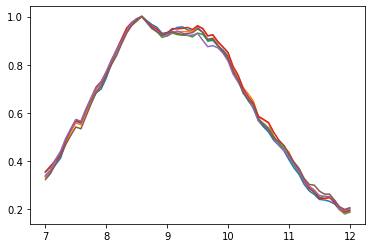

In [252]:
transmission1 =[] 
for i in range(len(temps)):
    temp = temps[i];
    intensity = planck(wavelengths*1e-6, temp  + 273.15)

    ref =  intensity/np.max(intensity)
    data = np.transpose(response1)[i]
    offset = data - np.min(data)
    norm = offset/np.max(offset)

    plt.plot(wavelengths, 1-(intensity/np.max(intensity)-norm)) 
    transmission1.append(1-(intensity/np.max(intensity)-norm))
plt.show()

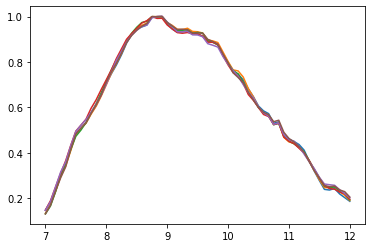

In [253]:
transmission2 =[] 
for i in range(len(temps)):
    temp = temps[i];
    intensity = planck(wavelengths*1e-6, temp  + 273.15)

    ref =  intensity/np.max(intensity)
    data = np.transpose(response2)[i]
    offset = data - np.min(data)
    norm = offset/np.max(offset)

    plt.plot(wavelengths, 1-(intensity/np.max(intensity)-norm)) 
    transmission2.append(1-(intensity/np.max(intensity)-norm))
plt.show()

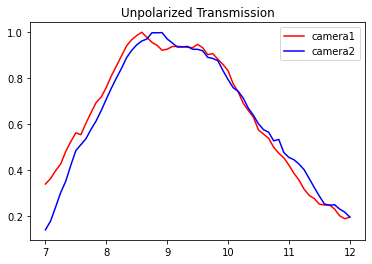

In [254]:
plt.plot(waves,np.mean(transmission1,0),'r',label = "camera1")
plt.plot(waves,np.mean(transmission2,0),'b',label = "camera2")
plt.title("Unpolarized Transmission")
plt.legend()
plt.show()